In [819]:
import pandas as pd
from csv import writer
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Input, LSTM, Conv1D, Conv2D, Reshape, Dense, BatchNormalization, Dropout, concatenate
from keras.callbacks import ModelCheckpoint
from model import build_model

In [820]:
WINDOW_SIZE = 20
OFFSET = 1
DIFFS = [4]

In [821]:
apcs = [f'ap_{i}' for i in range(10)]
avcs = [f'av_{i}' for i in range(10)]
bpcs = [f'bp_{i}' for i in range(10)]
bvcs = [f'bv_{i}' for i in range(10)]

keys = [x for ap, av, bp, bv in zip(apcs, avcs, bpcs, bvcs) for x in [ap, av, bp, bv]]
features = ['timestamp', 'bid_diff_feature_1', 'ask_diff_feature_1']
targets = [f'bid_diff_target_{i}' for i in DIFFS]

# Data

In [822]:
pd.set_option('max_rows', 100)

In [823]:
df = pd.read_csv('_input/data.csv')
df

timestamp  best_bid_price  best_ask_price  estimated_delivery_price  \
0     1625848394814         33561.0         33561.5                  33564.07   
1     1625848397615         33561.0         33561.5                  33562.27   
2     1625848397963         33557.0         33557.5                  33562.27   
3     1625848399819         33557.0         33557.5                  33559.87   
4     1625848400900         33557.0         33557.5                  33559.73   
...             ...             ...             ...                       ...   
4641  1625854652036         33419.5         33420.0                  33419.86   
4642  1625854653107         33410.0         33415.0                  33418.55   
4643  1625854654001         33408.5         33415.0                  33418.55   
4644  1625854656038         33408.5         33415.0                  33419.77   
4645  1625854657036         33408.5         33415.0                  33420.95   

      index_price  mark_price  open_interest  settlement_price   change_id  \
0        33564.07    33558.39     2890156196          32884.83  6096365586   
1        33562.27    33555.87     2890156196          32884.83  6096365722   
2        33562.27    33555.31     2890156186          32884.83  6096365846   
3        33559.87    33551.02     2890156186          32884.83  6096365981   
4        33559.73    33549.10     2890156186          32884.83  6096366013   
...           ...         ...            ...               ...         ...   
4641     33419.86    33413.12     2890795596          32884.83  6096784105   
4642     33418.55    33412.15     2890795596          32884.83  6096784275   
4643     33418.55    33412.20     2890795596          32884.83  6096784322   
4644     33419.77    33413.46     2890795596          32884.83  6096784374   
4645     33420.95    33414.61     2890795596          32884.83  6096784391   

         ap_0  ...     bp_7     bv_7     ap_8     av_8     bp_8     bv_8  \
0     33561.5  ...  33551.0  10640.0  33589.5  19430.0  33550.0     10.0   
1     33561.5  ...  33551.0  10640.0  33587.0   1200.0  33550.0     10.0   
2     33557.5  ...  33548.5    500.0  33565.0  33560.0  33547.0     10.0   
3     33557.5  ...  33548.5    500.0  33565.0  33560.0  33547.0     10.0   
4     33557.5  ...  33548.5    500.0  33565.0  33560.0  33547.0     10.0   
...       ...  ...      ...      ...      ...      ...      ...      ...   
4641  33420.0  ...  33409.0  22500.0  33427.5   7700.0  33408.5   7000.0   
4642  33415.0  ...  33403.5    500.0  33423.5   5810.0  33403.0     10.0   
4643  33415.0  ...  33403.0     10.0  33423.5   5810.0  33402.5  11760.0   
4644  33415.0  ...  33403.0     10.0  33423.5   5810.0  33402.5  11760.0   
4645  33415.0  ...  33403.0     10.0  33423.5   5810.0  33402.5  11760.0   

         ap_9     av_9     bp_9     bv_9  
0     33590.0   4540.0  33549.0  24720.0  
1     33589.5  19430.0  33549.0  24720.0  
2     33566.0  18730.0  33546.5     20.0  
3     33566.0  18730.0  33546.5     20.0  
4     33566.0  18730.0  33546.5     20.0  
...       ...      ...      ...      ...  
4641  33428.5    100.0  33408.0  19380.0  
4642  33424.0  26190.0  33402.5  11760.0  
4643  33424.0  26190.0  33402.0  55200.0  
4644  33424.0  26190.0  33402.0  55200.0  
4645  33424.0  26190.0  33402.0  55200.0  

[4646 rows x 49 columns]

In [824]:
def prepare_df(df):

    dfs = []

    for diff in DIFFS:
        dfs.append(-df[['best_bid_price', 'best_ask_price']].diff(-diff).rename(columns={'best_bid_price': f'bid_diff_target_{diff}', 'best_ask_price': f'ask_diff_target_{diff}'}))

    df0 = df[['timestamp', 'best_bid_price', 'best_ask_price']].diff(1).rename(columns={'best_bid_price': f'bid_diff_feature_{1}', 'best_ask_price': f'ask_diff_feature_{1}'})
    df0['timestamp'] /= 1000.

    df1 = df[['best_bid_price', 'best_ask_price'] + keys]
    dfX = pd.concat([df1, df0, *dfs], axis=1)

    # set prices as relative differences
    dfX[apcs] = dfX[apcs].sub(dfX['ap_0'], axis=0)
    dfX[bpcs] = -dfX[bpcs].sub(dfX['bp_0'], axis=0)

    # remove nans
    dfX = dfX[~dfX.isna().any(axis=1)]

    # rescale volumes
    l = 10.
    u = 1000000.
    dfX[avcs + bvcs] = (dfX[avcs + bvcs] - l) / (u - l)

    dfX = dfX.reset_index(drop=True)
    return dfX

dfX = prepare_df(df)
dfX[:20]

best_bid_price  best_ask_price  ap_0     av_0  bp_0     bv_0  ap_1  \
0          33561.0         33561.5   0.0  0.15754  -0.0  0.00000   2.0   
1          33557.0         33557.5   0.0  0.13231  -0.0  0.00000   2.5   
2          33557.0         33557.5   0.0  0.13231  -0.0  0.00000   2.5   
3          33557.0         33557.5   0.0  0.13231  -0.0  0.00000   2.5   
4          33557.0         33557.5   0.0  0.13231  -0.0  0.00000   2.5   
5          33553.5         33561.5   0.0  0.00465  -0.0  0.00362   1.0   
6          33557.0         33557.5   0.0  0.16390  -0.0  0.00000   1.0   
7          33557.0         33557.5   0.0  0.16390  -0.0  0.00000   1.0   
8          33557.0         33557.5   0.0  0.11741  -0.0  0.00000   1.5   
9          33557.0         33557.5   0.0  0.09748  -0.0  0.00687   2.0   
10         33557.0         33557.5   0.0  0.09748  -0.0  0.00687   2.0   
11         33557.0         33557.5   0.0  0.06248  -0.0  0.01730   0.5   
12         33557.0         33557.5   0.0  0.09608  -0.0  0.00000   0.5   
13         33557.5         33558.0   0.0  0.00109  -0.0  0.14214   1.5   
14         33557.5         33558.0   0.0  0.00109  -0.0  0.14214   1.5   
15         33561.0         33563.5   0.0  0.03103  -0.0  0.00999   4.5   
16         33561.0         33563.5   0.0  0.03103  -0.0  0.00999   4.5   
17         33556.0         33563.5   0.0  0.03103  -0.0  0.06726   3.0   
18         33562.0         33562.5   0.0  0.07286  -0.0  0.01186   1.0   
19         33569.5         33570.0   0.0  0.00204  -0.0  0.07014   1.0   

       av_1  bp_1     bv_1  ...     bv_8  ap_9     av_9   bp_9     bv_9  \
0   0.00113   1.0  0.00001  ...  0.00000  28.0  0.01942   12.0  0.02471   
1   0.03998   2.0  0.00001  ...  0.00000   8.5  0.01872   10.5  0.00001   
2   0.03998   2.0  0.00001  ...  0.00000   8.5  0.01872   10.5  0.00001   
3   0.03998   2.0  0.00001  ...  0.00000   8.5  0.01872   10.5  0.00001   
4   0.03998   2.0  0.00001  ...  0.00000   8.5  0.01872   10.5  0.00001   
5   0.00012   0.5  0.00000  ...  0.00003  19.5  0.00391   32.5  0.00334   
6   0.02499   2.0  0.00001  ...  0.00616   7.0  0.01686   12.0  0.00003   
7   0.02499   2.0  0.00001  ...  0.00616   7.0  0.01686   12.0  0.00003   
8   0.02126   2.0  0.00001  ...  0.00616   8.0  0.03356   12.0  0.01607   
9   0.00013   2.0  0.00001  ...  0.00616   9.0  0.10172   11.0  0.00199   
10  0.00013   2.0  0.00001  ...  0.00616   9.0  0.09836   11.0  0.00199   
11  0.00149   2.0  0.00001  ...  0.07393  10.5  0.04215   10.0  0.00000   
12  0.00250   2.0  0.00001  ...  0.00616  10.0  0.13719   11.5  0.01873   
13  0.00012   0.5  0.03933  ...  0.00008  11.0  0.00049    7.5  0.01001   
14  0.00012   0.5  0.03933  ...  0.00008  11.0  0.00049    7.5  0.01001   
15  0.05045   2.5  0.00049  ...  0.07058  12.5  0.06456   11.0  0.00000   
16  0.05045   2.5  0.00049  ...  0.07058  12.5  0.06456   11.0  0.00000   
17  0.00299   1.0  0.02091  ...  0.00334  10.5  0.00335  110.5  0.00009   
18  0.03202   4.5  0.00055  ...  0.00403  11.0  0.01561    9.5  0.00001   
19  0.00119   6.5  0.00354  ...  0.00000   7.5  0.00199   34.5  0.00334   

    timestamp  bid_diff_feature_1  ask_diff_feature_1  bid_diff_target_4  \
0       2.801                 0.0                 0.0               -4.0   
1       0.348                -4.0                -4.0               -3.5   
2       1.856                 0.0                 0.0               -0.0   
3       1.081                 0.0                 0.0               -0.0   
4       0.921                 0.0                 0.0               -0.0   
5       1.001                -3.5                 4.0                3.5   
6       0.139                 3.5                -4.0               -0.0   
7       0.655                 0.0                 0.0               -0.0   
8       4.352                 0.0                 0.0               -0.0   
9       5.003                 0.0                 0.0                0.5   
10      1.521                 0.0    

In [828]:
def split(df, offset, window_size):
    
    # X1
    X1 = np.array([df.iloc[i*offset:i*offset+window_size][keys] for i in range((len(df) - window_size) // offset)])
    X1 = X1[:, :, :, np.newaxis]
    
    # X2
    X2 = np.array([df.iloc[i*offset:i*offset+window_size][features] for i in range((len(df) - window_size) // offset)])
    
    # y
    y = dfX.iloc[offset-1+window_size:len(df):offset][targets].to_numpy()
    y = 0.5 * (y >= -3.) + 0.5 * (y >= 3.)

    return X1, X2, y

(array([ 978.,    0.,    0.,    0.,    0., 2650.,    0.,    0.,    0.,
         993.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

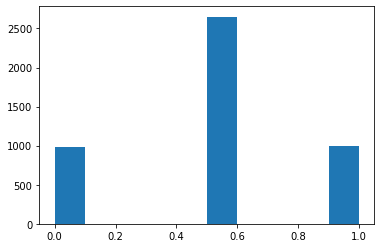

In [829]:
X1, X2, y = split(dfX, OFFSET, WINDOW_SIZE)
plt.hist(y)

In [831]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.15)

# Build model

In [856]:
def build_model(window_size, output_size):

    input_layer1 = Input(shape=(window_size, 40, 1))
    input_layer2 = Input(shape=(window_size, 3))

    x = Conv2D(10, kernel_size=(1, 2), strides=(1, 2), activation='relu')(input_layer1)
    x = Conv2D(10, kernel_size=(1, 2), strides=(1, 2), activation='relu')(x)
    x = Conv2D(10, kernel_size=(1, 10), activation='relu')(x)
    x = Reshape((window_size, -1))(x)

    x = concatenate([x, input_layer2])

    lstm_layer = LSTM(40)(x)
    bn_layer = BatchNormalization()(lstm_layer)
    dropout_layer = Dropout(0.2)(bn_layer)
    output_layer = Dense(output_size, activation='sigmoid')(dropout_layer)

    model = Model([input_layer1, input_layer2], output_layer)
    model.compile(optimizer='adam', loss='mse')

    return model


In [857]:
model = build_model(window_size=WINDOW_SIZE, output_size=len(DIFFS))
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 20, 40, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 20, 20, 10)   30          input_57[0][0]                   
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 20, 10, 10)   210         conv2d_84[0][0]                  
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 20, 1, 10)    1010        conv2d_85[0][0]                  
___________________________________________________________________________________________

In [ ]:
cp_callback = ModelCheckpoint(filepath='_output/model.h5', save_weights_only=True, save_best_only=True)
history = model.fit([X1_train, X2_train], y_train, epochs=200, validation_split=0.15, callbacks=[cp_callback], verbose=2)

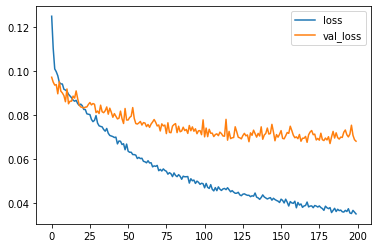

In [871]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [862]:
model.evaluate([X1_test, X2_test], y_test)

22/22 [==============================] - 0s 4ms/step - loss: 0.0814


0.0813889354467392

In [861]:
model.load_weights('_output/model.h5')

# Backtest

In [863]:
df2 = pd.read_csv('_input/data2.csv')
df2

timestamp  best_bid_price  best_ask_price  estimated_delivery_price  \
0     1626042520635         34354.0         34390.0                  34414.47   
1     1626042520861         34354.0         34390.0                  34414.47   
2     1626042523606         34354.0         34390.0                  34420.11   
3     1626042525674         34354.0         34390.0                  34417.25   
4     1626042526602         34354.0         34390.0                  34417.45   
...             ...             ...             ...                       ...   
3092  1626050041130         34249.5         34250.0                  34236.56   
3093  1626050045756         34243.5         34244.0                  34230.72   
3094  1626050050743         34243.5         34244.0                  34230.66   
3095  1626050055594         34243.5         34246.0                  34232.71   
3096  1626050056145         34243.5         34244.0                  34231.83   

      index_price  mark_price  open_interest  settlement_price   change_id  \
0        34414.47    34344.79     2889303196          33519.14  6104384614   
1        34414.47    34344.79     2889303196          33519.14  6104384650   
2        34420.11    34345.53     2889303196          33519.14  6104384695   
3        34417.25    34339.59     2889303196          33519.14  6104384839   
4        34417.45    34338.50     2889303196          33519.14  6104384865   
...           ...         ...            ...               ...         ...   
3092     34236.56    34248.95     2889619216          33519.14  6104652871   
3093     34230.72    34242.94     2889619216          33519.14  6104653068   
3094     34230.66    34242.25     2889619216          33519.14  6104653246   
3095     34232.71    34244.02     2889619216          33519.14  6104653290   
3096     34231.83    34243.14     2889619216          33519.14  6104653439   

         ap_0  ...     bp_7     bv_7     ap_8     av_8     bp_8     bv_8  \
0     34390.0  ...  34030.0    140.0  34438.0  16050.0  33876.0   1000.0   
1     34390.0  ...  34030.0    140.0  34438.0  16050.0  33876.0   1000.0   
2     34390.0  ...  34030.0    140.0  34438.0  16050.0  33876.0   1000.0   
3     34390.0  ...  34030.0    140.0  34441.0   2410.0  33876.0   1000.0   
4     34390.0  ...  34030.0    140.0  34441.0   2410.0  33876.0   1000.0   
...       ...  ...      ...      ...      ...      ...      ...      ...   
3092  34250.0  ...  34240.5  16270.0  34260.5   2400.0  34239.0  10100.0   
3093  34244.0  ...  34232.5     50.0  34254.5  39940.0  34232.0   1000.0   
3094  34244.0  ...  34233.5    500.0  34254.0  12970.0  34232.0   1090.0   
3095  34246.0  ...  34233.5    500.0  34254.5  22820.0  34232.0  50820.0   
3096  34244.0  ...  34233.5   1570.0  34254.5  25330.0  34232.5  17250.0   

         ap_9      av_9     bp_9     bv_9  
0     34438.5   84250.0  33859.5    140.0  
1     34438.5   84250.0  33859.5    140.0  
2     34438.5   84250.0  33859.5    140.0  
3     34442.5  103080.0  33859.5    140.0  
4     34442.5  103080.0  33859.5    140.0  
...       ...       ...      ...      ...  
3092  34268.5     140.0  34238.5   1070.0  
3093  34255.0    3950.0  34231.5   1440.0  
3094  34254.5   22820.0  34231.5  17870.0  
3095  34255.0    4410.0  34231.5  17870.0  
3096  34255.0    4410.0  34232.0  49730.0  

[3097 rows x 49 columns]

In [864]:
X1, X2, y = split(dfX, 1, WINDOW_SIZE)
ret_pred = model.predict([X1, X2])
dff = dfX.loc[20:, ['bid_diff_target_4', 'ask_diff_target_4']]
dff.loc[:, 'pred_4'] = ret_pred.reshape(-1)
dff.loc[:, 'y'] = y.reshape(-1)
dff = dff[~dff['pred_4'].isna()]
dff[:200].style.background_gradient(cmap='coolwarm')

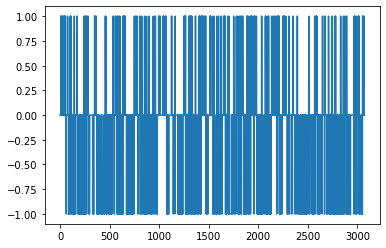

In [866]:
# load backtest dataset
dfY = prepare_df(df2)

# predict returns
X1, X2, y = split(dfY, 1, WINDOW_SIZE)
ret_pred = model.predict([X1, X2])

# create strategy
strategy = -1 + 1. * (ret_pred > 0.2) + 1. * (ret_pred > 0.8)
plt.step(np.arange(len(strategy)), strategy)

In [867]:
# create

dff = dfY.loc[20:, ['best_bid_price', 'best_ask_price', 'bid_diff_target_4', 'ask_diff_target_4']]
dff.loc[:, 'pred_4'] = ret_pred.reshape(-1)
dff.loc[:, 'strategy'] = strategy.reshape(-1)
dff = dff[~dff['pred_4'].isna()]

# normalize colors around zero
l, u = dff['bid_diff_target_4'].min(), dff['bid_diff_target_4'].max()
bid_low = (u + l) / (u - l)

l, u = dff['ask_diff_target_4'].min(), dff['ask_diff_target_4'].max()
ask_low = (u + l) / (u - l)

# display with cmap
dff.style.background_gradient(cmap='coolwarm', subset=(dff.index, ['pred_4', 'strategy'])).\
          background_gradient(cmap='coolwarm', low=bid_low, subset=(dff.index, ['bid_diff_target_4'])).\
          background_gradient(cmap='coolwarm', low=ask_low, subset=(dff.index, ['ask_diff_target_4']))

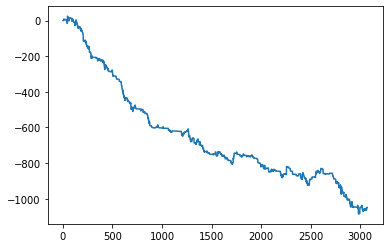

In [868]:
money = -np.maximum(np.diff(np.pad(strategy[:, 0], (1, 0)), axis=0), 0) * dfY['best_ask_price'].to_numpy()[WINDOW_SIZE-1:-1]
money += -np.minimum(np.diff(np.pad(strategy[:, 0], (1, 0)), axis=0), 0) * dfY['best_bid_price'].to_numpy()[WINDOW_SIZE-1:-1]
plt.plot(np.cumsum(money) + strategy[:, 0] * dfY['best_ask_price'].to_numpy()[WINDOW_SIZE:])